In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0
sys.version_info(major=3, minor=7, micro=8, releaselevel='final', serial=0)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)
print(housing.DESCR)

(20640, 8)
(20640,)
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which

In [3]:
import pprint
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [6]:
#实现多输入
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_wide, input_deep], outputs=[output])


model.summary()
model.compile(loss="mean_squared_error", optimizer="adam")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [11]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]


history = model.fit([x_train_scaled_wide, x_train_scaled_deep], 
                    y_train,
                   validation_data = ([x_valid_scaled_wide, x_valid_scaled_deep], y_valid),
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3448 - val_loss: 0.3446
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3309 - val_loss: 0.3492
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3415 - val_loss: 0.3482
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3433 - val_loss: 0.3412
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3295 - val_loss: 0.3487
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3239 - val_loss: 0.3576


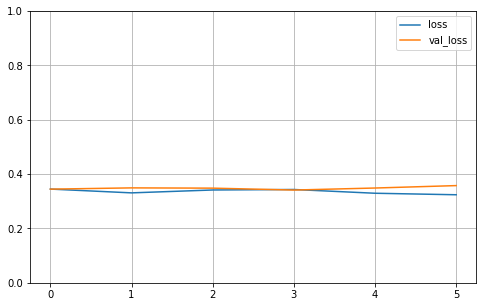

In [12]:
def plot_learn_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learn_curves(history)

In [13]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], y_test)

162/162 [==============================] - 0s 769us/step - loss: 0.3521


0.35206338763237